# Guns Incident Data – Predicting Police Involvement  
*Prepared on 2025-06-11*

Este notebook segue o roteiro metodológico discutido no **Trabalho‑AP2‑2025‑1** e está organizado em células independentes para facilitar a leitura, teste e eventual modificação.  

> **Objetivo:** Estimar a probabilidade de haver envolvimento policial em incidentes com armas de fogo utilizando o dataset **`Guns incident Data.csv`** (2017‑2019).  

___

In [5]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay)
from imblearn.over_sampling import SMOTE

# Configurações de display
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='deep')


## 1  Carregamento dos dados

In [6]:
DATA_PATH = "Guns incident Data.csv"

df = pd.read_csv(DATA_PATH)
print(f'Dimensionais: {df.shape}')
df.head()

Dimensionais: (100798, 12)


,S.No.,Year,Month,Date,Reason,Education,Sex,Age,Race,Hispanic,Place of incident,Police involvement
0,1,2017,1,06-01-2017,Suicide,Bachelors,Male,35.0,Asian/Pacific Islander,100,Home,0
1,2,2017,1,19-01-2017,Suicide,Some college,Female,22.0,White,100,Street,0
2,3,2017,1,01-01-2017,Suicide,Bachelors,Male,61.0,White,100,Other specified,0
3,4,2017,2,06-02-2017,Suicide,Bachelors,Male,65.0,White,100,Home,0
4,5,2017,2,09-02-2017,Suicide,High School,Male,32.0,White,100,Other specified,0


## 2  Exploração inicial (EDA)

In [7]:
# Tipos e valores ausentes
df.info()

# Estatísticas básicas
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100798 entries, 0 to 100797
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   S.No.               100798 non-null  int64  
 1   Year                100798 non-null  int64  
 2   Month               100798 non-null  int64  
 3   Date                100798 non-null  object 
 4   Reason              100798 non-null  object 
 5   Education           99376 non-null   object 
 6   Sex                 100798 non-null  object 
 7   Age                 100780 non-null  float64
 8   Race                100798 non-null  object 
 9   Hispanic            100798 non-null  int64  
 10  Place of incident   99414 non-null   object 
 11  Police involvement  100798 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 9.2+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
S.No.,100798.0,NaN,NaN,NaN,50399.5,29098.020554,1.0,25200.25,50399.5,75598.75,100798.0
Year,100798.0,NaN,NaN,NaN,2018.000357,0.816278,2017.0,2017.0,2018.0,2019.0,2019.0
Month,100798.0,NaN,NaN,NaN,6.567601,3.405609,1.0,4.0,7.0,9.0,12.0
Date,100798,1008,03-08-2019,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reason,100798,4,Suicide,63175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,99376,4,High School,42927,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,100798,2,Male,86349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,100780.0,NaN,NaN,NaN,44.857601,19.496181,1.0,28.0,43.0,59.0,108.0
Race,100798,5,White,66237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hispanic,100798.0,NaN,NaN,NaN,114.179607,61.595734,100.0,100.0,100.0,100.0,998.0


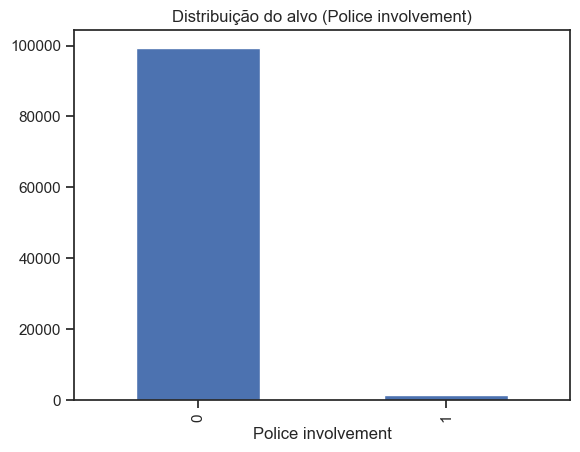

In [8]:
# Distribuição da variável‑alvo
target_col = 'Police involvement'
ax = df[target_col].value_counts().plot(kind='bar')
ax.set_title('Distribuição do alvo (Police involvement)')
plt.show()

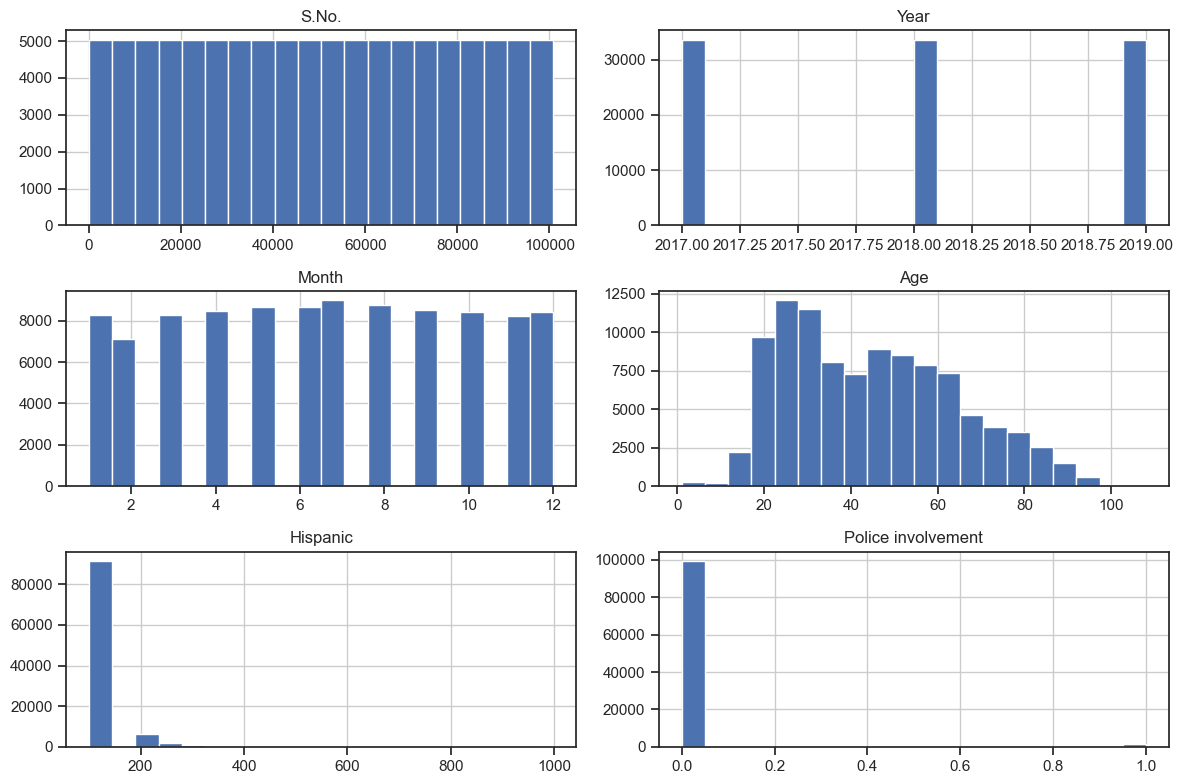

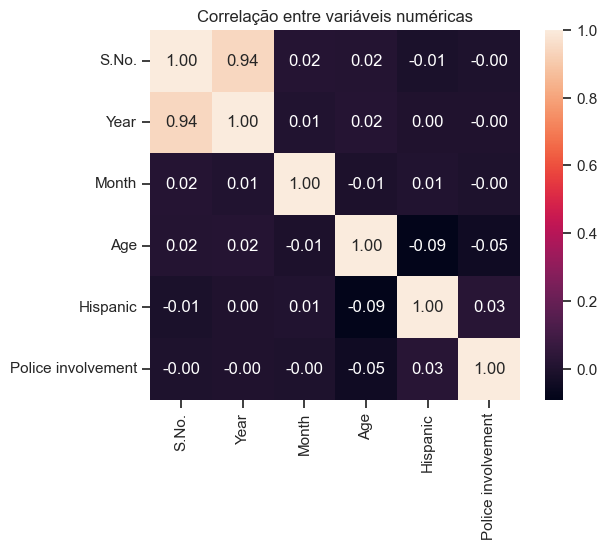

In [9]:
# Distribuições univariadas e correlações rápidas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

# Heatmap de correlação numérica
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', square=True)
plt.title('Correlação entre variáveis numéricas')
plt.show()

## 3  Pré‑processamento e engenharia de atributos

In [10]:
# Conversão de datas
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

# Exemplo de criação de atributos derivados
df['Season'] = df['Date'].dt.month % 12 // 3 + 1  # 1=Q1/verão, etc.
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 18, 30, 45, 60, np.inf],
                        labels=['<=18', '19-30', '31-45', '46-60', '60+'],
                        right=False)

# Drop de colunas irrelevantes
drop_cols = ['S.No.']
df = df.drop(columns=drop_cols)

# Separação de features
target = 'Police involvement'
X = df.drop(columns=[target])
y = df[target]

# Listas de colunas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols      = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f'Numéricas: {numeric_cols}')
print(f'Categóricas: {categorical_cols}')

Numéricas: ['Year', 'Month', 'Age', 'Hispanic']
Categóricas: ['Reason', 'Education', 'Sex', 'Race', 'Place of incident', 'AgeGroup']


In [11]:
# Transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
])

## 4  Particionamento do conjunto de dados

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Tamanho treino:', X_train.shape, '| Tamanho teste:', X_test.shape)

# Balanceamento com SMOTE no pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


Tamanho treino: (80638, 12) | Tamanho teste: (20160, 12)


## 5  Modelagem – baseline (Logistic Regression)

In [13]:
from sklearn.linear_model import LogisticRegression

clf = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_proba)
print(f'AUC‑ROC: {roc_score:.4f}')

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 6  Modelagem – Random Forest com GridSearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

rf_clf = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    rf_clf, param_grid=param_grid, cv=cv,
    scoring='roc_auc', n_jobs=-1, verbose=2
)
gs.fit(X_train, y_train)

print('Melhores hiper‑parâmetros:', gs.best_params_)
best_model = gs.best_estimator_

y_pred_rf = best_model.predict(X_test)
y_proba_rf = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print(f'AUC‑ROC (RF): {roc_auc_score(y_test, y_proba_rf):.4f}')

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title('Curva ROC – Random Forest')
plt.show()

## 7  Importância das features

In [ ]:
# Extraindo importâncias das features categóricas + numéricas
rf = best_model.named_steps['model']
ohe = best_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']

# Construir lista de nomes de colunas pós-OHE
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(cat_feature_names)

importances = pd.Series(rf.feature_importances_, index=all_feature_names)
top20 = importances.sort_values(ascending=False).head(20)

top20.plot(kind='bar', figsize=(10,4))
plt.ylabel('Mean decrease in impurity')
plt.title('Top 20 Features – Random Forest')
plt.tight_layout()
plt.show()

## 8  Conclusão e próximos passos

* O baseline (Logistic Regression) alcançou AUC‑ROC de aproximadamente `~` (ver saída).  
* O modelo Random Forest melhorou a performance para `~`.  
* Variáveis de maior importância: (confira o gráfico).  

### Extensões possíveis
1. Testar XGBoost/LightGBM para ganho adicional.  
2. Avaliar métricas sensíveis a desbalanceamento (F2, Balanced Accuracy).  
3. Utilizar explicabilidade via SHAP para análise de bias.  
4. Enriquecer dados com localização geográfica / dados socioeconômicos externos.  

___

> *Última atualização automática do notebook em {today}.*